---
title: "Supervised Machine Learning With Scikit-learn and Diabetes"
subtitle: ""
summary: ""
authors: []
tags:
  - python
  - knn
  - regression
  - randomforest
  - ML
  - supervised
  - sklearn
  - classifier 
  
categories: [Python]
date: 2019-05-28T19:26:32-04:00
#lastmod: 2019-06-28T19:26:32-04:00
featured: false
draft: false

#Featured image
#To use, add an image named `featured.jpg/png` to your page's folder.
#Focal points: Smart, Center, TopLeft, Top, TopRight, Left, Right, BottomLeft, Bottom, BottomRight.
image:
  caption: ""
  focal_point: ""
  preview_only: false

#Projects (optional).
#Associate this post with one or more of your projects.
#Simply enter your project's folder or file name without extension.
#E.g. `projects = ["internal-project"]` references `content/project/deep-learning/index.md`.
#Otherwise, set `projects = []`.
projects: []

---

In this post, I will explore and configure a few classification algorithms (supervised machine learniIn this post, I will explore and configure a few classification algorithms (supervised machine learning). I originally wanted to apply ML and fit some models on diabetes data. The diabetes dataset is one of the most well known data available to ML enthusiasts for their learning purposes.
After I had started writing my script for the post, I found an [article](https://towardsdatascience.com/machine-learning-workflow-on-diabetes-data-part-01-573864fcc6b8) written by Lahiru Liyanapathirana more than an year ago. It turned out that Lahiru wrote his article with the same intention; i.e. to fit the best suitable model. He did a great job and exhausted a wide range of suitable algorithms from Scikit-learn. However, this did not discourage me! Unlike Lahiru, I will focus only on four classifiers consecutively. Specifically, i.) k-nearest neighbor (k-NN), ii.) logistic regression, iii.) decision tree and iv.) random forest.
However, and in addition to Lahiru’s article, I will show and introduce a few “new” techniques. First, I will share how and why I handled the missing data differently (this turned out to have a negative impact on performance). Secondly, I will be fitting the model using `Pipeline` and `SimpleImputer` as the arguments of `GridSearchCV`. To achieve the best performance and generality, I will be also tuning the hyperparameters for every model individually. Last but not least, I maintain that accuracy is not and should not be the only criteria when evaluating the model’s performance!


# Loading the necessary packages
I loaded the following packages according to their consecutive roles in the process.

In [65]:
# data handeling
import pandas as pd
import numpy as np

# Data preprocessing for ML
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# model traning and testing faciliators
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import StandardScaler

# Overfiitting/underfitting guide
from sklearn.model_selection import GridSearchCV

# ML models to be explored
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Performace measurements
from sklearn.metrics import classification_report

# Visualization
import scikitplot as skplt
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [133]:
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category= FutureWarning)

## Exploratory Data Analysis (EDA)

In [67]:
df = pd.read_csv("diabetes_data.csv")

In [68]:
df.head()

,pregnancies,glucose,diastolic,triceps,insulin,bmi,dpf,age,diabetes
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Looking at the head of the data frame, there are several 0 values. Aside from the label (binominal diabetes), the observation suggests some missing data! I bet if your insulin level was 0 and you would be still reading these lines, on a funny note you probably would be the first undead person interested in ML.

In [69]:
df.describe()

,pregnancies,glucose,diastolic,triceps,insulin,bmi,dpf,age,diabetes
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Based on the summary statistics, `min` indicates other features with missing values: i.) `glucose` ii.) `diastolic` (blood pressure), iii.) `triceps`, iv.) `bmi`, i.e. $bmi = \frac{body weight}{height}$. Frankly, anyone with 0 blood pressure or bmi (body-mass-index) must be dead. Therefore, it is necessary to clean the data.

In [70]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
pregnancies    768 non-null int64
glucose        768 non-null int64
diastolic      768 non-null int64
triceps        768 non-null int64
insulin        768 non-null int64
bmi            768 non-null float64
dpf            768 non-null float64
age            768 non-null int64
diabetes       768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


pregnancies    0
glucose        0
diastolic      0
triceps        0
insulin        0
bmi            0
dpf            0
age            0
diabetes       0
dtype: int64

There are 768 all numeric records with no `NaN`. Therefore, `0` values in the data represent missing records. How many “zeros” are in each column of the data frame (`df`)? I answered the question with a for loop and `count_nonzero()` method of NumPy array.

In [71]:
for colname in df.columns[:8]:
    print('0s in "{variable}": {count}'.format(
        variable=colname,
        count=np.count_nonzero(df[colname] == 0)))

0s in "pregnancies": 111
0s in "glucose": 5
0s in "diastolic": 35
0s in "triceps": 227
0s in "insulin": 374
0s in "bmi": 11
0s in "dpf": 0
0s in "age": 0


In general, there are three approaches in which a data scientist could handle so many missing values and they are as below:
1.	Delete any observation with missing values, which would result in substantial loss of data.
2.	Substitute missing values with either mean, median, or mode; which can be a great trade between regression to the mean but keeping the data. However, it is not the best solution when it comes to the substitution of more than half of values in a variable.
3.	Give up; hell no.

**Before dealing with the missing values, let’s examine the data visually**. Since Lahiru already presented the histograms of the variables, I have decided to expand the insight by examining the box plots. Unlike the histogram, a box plot is a great tool to identify outliers in the data.

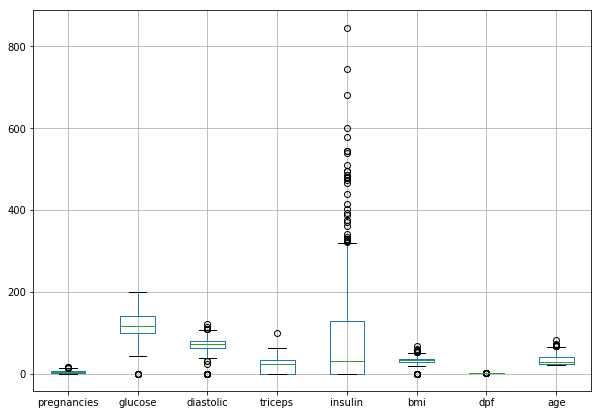

In [72]:
df.drop("diabetes",axis=1).boxplot(figsize = [10, 7])
plt.show()

Obviously, the variables exhibit various distribution patterns. For example, `insulin` reaches both the greatest maxima and exhibits many overlapping outliers. Its distribution is right-skewed, and I expect the variable is a very strong predictor for the diagnosis of diabetes. You do not have to be an expert in ML but I do not think the data is the best sample for ML. Firstly, there are a lot of missing values. Secondly, ML is not very effective when it comes to handling outliers.

Since, I will be using `RandomForestClassifier`, there is a way to quickly and visually investigate the importance of these features. This is the tool: `skplt.estimators.plot_feature_importances`. It plots the classifier’s feature importance. You can visually inspect how much the variable, relative to other features, correlates to the occurrence of diabetes.

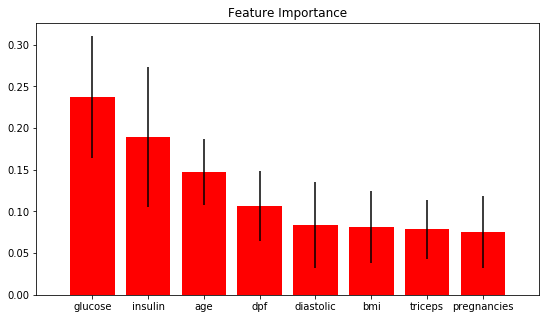

In [73]:
df2 = df[(df.insulin !=0) & (df.bmi !=0) & (df.pregnancies !=0) & (df.glucose !=0)]
feature_names = df2.columns[:-1]

randfor = RandomForestClassifier()
randfor.fit(df2.drop(columns = "diabetes", axis=1),df2["diabetes"])

skplt.estimators.plot_feature_importances(randfor, feature_names=feature_names, figsize=(9, 5))
plt.show()

The result supports my assumption that `glucose` is a very strong predictor for the presence of diabetes.

### Data Wrangling 
I see nothing wrong in deleting a few observations with missing values, however, in my case the approach would result in a loss of too many observations. Lahirru has probably realized the same and therefore deleted only the rows with missing data in `glucose`, `diastolic`, and `bmi`. Therefore, he deleted only a small fraction of all observations.
To deal with the issue in my own way, I have decided to combine 1.) and 2.) approaches discussed above. I was curious whether I would achieve higher accuracy and precision and what recall would be. For the sake of learning, I even decided to share my experience regardless of the result.
I designed my approach as follows: 
* Firstly, I decided to delete every row where the number of `0s` was greater than 1. On the other hand, I made the assumption which probably does not hold, i.e., pregnancies do not exhibit any missing values and observed `0s` are valid records indicating that the person is not pregnant. 
* Secondly, I replaced the remaining missing values with a `mode. 
    * I will handle the operation using SimpleImputer in the Pipeline while fitting the model to the training data set and predicting.

The following chunk of code summarizes the first step of my approach:

In [74]:
for index,row in df.iterrows():
    zero_count = row[1:6]
    if np.count_nonzero(zero_count==0) > 1:
        df.drop(index, inplace=True)

df.shape

(534, 9)

As a result, I deleted only 234 rows. Deleting every observation with a missing value would result in loss of at least 374 rows.

In [75]:
for colname in df.columns[:8]:
    print('Ex-post0s in "{variable}": {count}'.format(
        variable=colname,
        count=np.count_nonzero(df[colname] == 0)))

Ex-post0s in "pregnancies": 78
Ex-post0s in "glucose": 1
Ex-post0s in "diastolic": 0
Ex-post0s in "triceps": 0
Ex-post0s in "insulin": 140
Ex-post0s in "bmi": 1
Ex-post0s in "dpf": 0
Ex-post0s in "age": 0


Lastly, one should examine correlations between the variables and label. There are many ways to do so, but I particularly prefer the heat map.

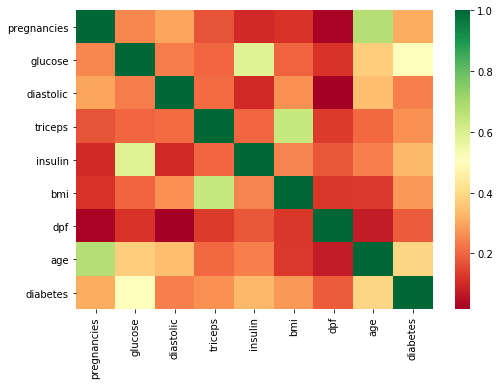

In [76]:
plt.figure(figsize = [8, 5.5])
sns.heatmap(df2.corr(), square=False, cmap='RdYlGn')
plt.show()

I evaluated the correlations from three perspectives; i.e.,1.) General pattern, 2.) Correlation between `diabetes` and other variables, 3.) Correlation amongst all variables. 
1. The data set contains only variables positively correlated with presence of `diabetes`.

2. Most of the times, the variables exhibit low correlations between themselves and `diabetes`. However, `glucose` and `age` seem to be much more correlated with the target than other variables. 

3. All the features are mostly uncorrelated. However, you can notice correlations above 0.6 between:
    * `age` and `pregnancies` 
    * `glucose` and `insulin` 
    * `triceps` and `bmi`
    
I consulted a relative of mine who studies  medicine to take a look at the observations. She confirmed the correlations are in line with her expectancy.
Finally, I substituted every `0` in the data frame (except in the label) with `NaN`:

Finally, I substitued  every `0` in the data frame (except in the label) with `NaN` :

In [77]:
df.glucose.replace(0, np.nan, inplace = True)
df.insulin.replace(0, np.nan, inplace = True)
df.bmi.replace(0, np.nan, inplace = True)

### Pre-setting and Modeling Strategy
Last but not least, I split the data into labels and 2D arrays for training and testing as is the standard (and not rocket science) approach in ML.

In [78]:
X = df.drop(columns = "diabetes", axis=1)
y = df["diabetes"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

#### Imputer
Referring back to the second step in my proposed approach, I utilized `SimpleImputer` and I passed it into `Pipeline`.  The function substitutes `NaN` with a chosen value relative to the variable, e.g. `mean`, `mode`, etc.

In [79]:
imp = SimpleImputer(strategy = "most_frequent", missing_values = np.nan)

The **following steps** summarize my approach to fit a particular model. Moreover, I designed the logic to be perfectly replicable:

1. create the list `steps_model` containing functions:
    * `imp`
    * `StandardScaler`
    * `model`
    
    
2. create `pipeline_model` by calling `Pipeline`
    * pass `steps_model` as the argument 
    
    
3. Create a list `parameters_model` 
    * the object contains the parameters of a particular model with ranges of values
    
    
4. Create `cv_model` by calling `GridSearchCV` (cross validation) 
    * Specify the arguments as follows: `pipeline _model , param_grid = parameters_model, scoring = "roc_auc", cv = 5` 
    
    
5. Call `cv_model.fit(X_train, y_train)` to train a model


6. Predict the label `pred_model` by calling `cv_model.predict(X_test)`


7. Evaluate performance by:
    * `cv_model.best_params_(y_test, pred_model)`
    * `accuracy_score(y_test, pred_model)`
    * `classification_report(y_test, pred_model)`

**The strategy is identical to all the models that I will attempt to fit, i.e.: i.) k-nearest neighbor (k-NN), ii.) logistic regression, iii.) decision tree and iv.) random forest.**
Therefore, , I will discuss the key issues only in `I.)k - Nearest Neighbour`. I am intentionally avoiding commenting on other models because the logic remains the same. However,  the list** `parameters_model` **should be unique to each classifier because the parameters differ from model to model.**
**I will comment on the performance and draw a conclusion in the last part of the article.**

### I.) K - Nearest Neighbour

In [80]:
# Step 1.
steps_knn = [("imputation", imp),
         ("scaler", StandardScaler()),
         ("knn", KNeighborsClassifier())]

In [81]:
# Step 2.
pipeline_knn = Pipeline(steps_knn)

In [82]:
# Step 3. For KNN, I only specified the range of paramters from 1 to 51.
parameters_knn = {"knn__n_neighbors":np.arange(1,51)}

In [83]:
# Step 4.
cv_knn = GridSearchCV(pipeline_knn, param_grid = parameters_knn, scoring = "roc_auc", cv = 5 )

###### Training the Model (Step 5.)
By calling `cv_model` on the label and 2D data frame, the function utilizes all the steps from `steps_model`at first. Specifically, **only and only the data is**: i.) cleaned (NaNs substituted with the mode), ii.) standardized, iii.) **it can be classified by the classifier**.   Additionally, the process goes hand in hand with `GridSearchCV` what splits `X_train` and `y_train` into 5 identical data sets and performs cross-validation on each of them. However, each data set is split into different test and train sections. While cross-validating, `GridSearchCV` searches for the best parameters specified in `parameters_model`.

In [84]:
# Step 5.
cv_knn.fit(X_train, y_train) 

/Users/jiristodulka/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('imputation', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='most_frequent', verbose=0)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'knn__n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [85]:
# Step 6.
pred_knn = cv_knn.predict(X_test)

##### Measuring Performance (Step 7.)
`classification_report` is one of the methods to see a bigger picture of the model’s performance. Since I classified the binary variable relevant to human health, I want to focus on the `precision` and  `recall`.

* `precision` is also called **positive predictive value (PPV)**. Mathematically: $PPV = \frac{TP}{TP+FP}$ It is similar to accuracy, but focuses only on data the model has predicted  to be positive, i.e. `diabetes = 1`. Referring to a confusion matrix, `precision` of 1 means that there were no false positives.
* `recall`, also called sensitivity OR True Positive Rate (TPR), answers the question on how complete the results are, i.e. did the model miss any positive classes and to what extent? Mathematically expressed:$TPR = \frac{TP}{TP+FN}$ In our case, low `recall` would mean that the model has incorrectly classified a lot of individuals with diabetes as healthy ones.

One should ask, what is the superior metric from the two? **A friend of mine, a data scientist, told me he was asked the same at his interview**. In fact, it really depends! 
For example, imagine cancer diagnostics, would you rather classify few more patients as false positive and after more precise examination conclude they had no cancer or would you rather let escape the ones with cancer as healthy individuals? **In this particular case, the model should minimize $FN$ in the confusion matrix. Consequently, recall,i.e. TPR, which should be closer to 1.**
Lastly, there is always a trade-off between the two negatively correlated metrics.

In [86]:
# Step 7.
print("KNN Parameters are: {}".format(cv_knn.best_params_))
print("KNN Accuracy is: {}".format(accuracy_score(y_test, pred_knn)))
print(classification_report(y_test, pred_knn))

KNN Parameters are: {'knn__n_neighbors': 47}
KNN Accuracy is: 0.7142857142857143
              precision    recall  f1-score   support

           0       0.70      0.96      0.81       100
           1       0.83      0.31      0.45        61

   micro avg       0.71      0.71      0.71       161
   macro avg       0.76      0.64      0.63       161
weighted avg       0.75      0.71      0.67       161



### II.) Logistic Reg

In [105]:
# Steps 1. & 2.
pipeline_logreg = Pipeline([("imputation", imp),
         ("scaler", StandardScaler()),
         ("logreg", LogisticRegression())])

In [106]:
# Step 3.
parameters_logreg = {"logreg__C":np.arange(0.1, 1.1, 0.1),
             "logreg__penalty":("l1", "l2")}

In [107]:
# Step 4.
cv_logreg = GridSearchCV(pipeline_logreg, param_grid = parameters_logreg, cv = 5 )

In [108]:
# Step 5.
cv_logreg.fit(X_train,y_train)

/Users/jiristodulka/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('imputation', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='most_frequent', verbose=0)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logreg', LogisticRegression(C=1.0, class_weight=None, dual=Fa...enalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'logreg__C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]), 'logreg__penalty': ('l1', 'l2')},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [111]:
# Step 6.
pred_logreg = cv_logreg.predict(X_test)

### III.) Decision Tree

In [112]:
# Steps 1. & 2.
pipeline_dectree = Pipeline([("imputation", imp),
         ("scaler", StandardScaler()),
         ("dectree", DecisionTreeClassifier())])

In [113]:
# Step 3.
parameters_dectree = {'dectree__max_features': ['auto', 'sqrt', 'log2', None],
          #'dectree__min_samples_split': np.arange(2, 15), 
          #'dectree__min_samples_leaf':np.arange(2, 15),
          'dectree__random_state':[42]}

In [114]:
# Step 4.
cv_dectree = GridSearchCV(pipeline_dectree, param_grid = parameters_dectree, cv = 5 )

In [115]:
# Step 5.
cv_dectree.fit(X_train,y_train)

/Users/jiristodulka/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('imputation', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='most_frequent', verbose=0)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dectree', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            ...      min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'dectree__max_features': ['auto', 'sqrt', 'log2', None], 'dectree__random_state': [42]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [116]:
# Step 6.
pred_dectree = cv_dectree.predict(X_test)

### IV.) Random Forest

In [117]:
pipeline_randfst = Pipeline([("imputation", imp),
         ("scaler", StandardScaler()),
         ("randfst", RandomForestClassifier())])

In [118]:
paraparameters_randfst = {"randfst__n_estimators": np.arange(5,200,5),
                          "randfst__criterion":['gini','entropy'],
                          #"randfst__n_jobs":[-1],
                          "randfst__random_state":[42]}

In [119]:
cv_randfst = GridSearchCV(pipeline_randfst, param_grid = paraparameters_randfst, cv = 5)

In [120]:
cv_randfst.fit(X_train, y_train)

/Users/jiristodulka/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('imputation', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='most_frequent', verbose=0)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('randfst', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            ...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'randfst__n_estimators': array([  5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,  65,
        70,  75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125, 130,
       135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195]), 'randfst__criterion': ['gini', 'entropy'], 'randfst__random_state': [42]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [121]:
pred_randfst = cv_randfst.predict(X_test)

### Step 7. &  Best Model Selection
I already mentioned `precision` and `recall` but did explain `accuracy`. In fact, `accuracy` may  not be the best parameter for choosing the right model. Consider test data with 100 individuals from which 99 subjects are healthy ones and only 1 individual has diabetes. Also, assume the model successfully classified 99 healthy people but completely failed to classify the one individual with diabetes. 

Gived that $accuracy = \frac{TP + TN} {TP + TN + FP + FN}$, than the accuracy would be 99%. However, the algorithm missed 100% individuals in the positive class.

The following code displays the best parameters and accuracy of every classifier I fit. Moreover, `classification_report` displays the table with `recall` and `precision`, so you can effectively evaluate each model.

In [123]:
print("KNN Parameters are: {}".format(cv_knn.best_params_))
print("KNN Accuracy is: {}".format(accuracy_score(y_test, pred_knn)))
print(classification_report(y_test, pred_knn))

print("Log. reg Parameters are: {}".format(cv_logreg.best_params_))
print("Log. reg accuracy is: {}".format(accuracy_score(y_test, pred_logreg)))
print(classification_report(y_test, pred_logreg))

print("Dec. tree Parameters are: {}".format(cv_dectree.best_params_))
print("Dec. tree accuracy is: {}".format(accuracy_score(y_test, pred_dectree)))
print(classification_report(y_test, pred_dectree))

print("Rand. forest Parameters are: {}".format(cv_randfst.best_params_))
print("Rand. forest accuracy is: {}".format(accuracy_score(y_test, pred_randfst)))
print(classification_report(y_test, pred_randfst))

KNN Parameters are: {'knn__n_neighbors': 47}
KNN Accuracy is: 0.7142857142857143
              precision    recall  f1-score   support

           0       0.70      0.96      0.81       100
           1       0.83      0.31      0.45        61

   micro avg       0.71      0.71      0.71       161
   macro avg       0.76      0.64      0.63       161
weighted avg       0.75      0.71      0.67       161

Log. reg Parameters are: {'logreg__C': 0.1, 'logreg__penalty': 'l2'}
Log. reg accuracy is: 0.7639751552795031
              precision    recall  f1-score   support

           0       0.76      0.91      0.83       100
           1       0.78      0.52      0.63        61

   micro avg       0.76      0.76      0.76       161
   macro avg       0.77      0.72      0.73       161
weighted avg       0.77      0.76      0.75       161

Dec. tree Parameters are: {'dectree__max_features': None, 'dectree__random_state': 42}
Dec. tree accuracy is: 0.6708074534161491
              precision   

As you can see, the logistic model performs with the highest accuracy of 0.77 meaning the model predicted 77% of cases correctly. However, you do not want to send any patient home with diabetes as if she was healthy. From this perspective, you should choose the model with `recall` close to 1. Since, the logistic model has `recall = 0.57`, you may consider to decide for the **decision tree classifier**. Considering overall accuracy, the model performs by 10 p.p. worse. However, it has the largest `recall` from all the considered classifiers. Administering this model, you would have sent home the lowest possible number of patients with diabetes at the cost of reexamining greater number of healthy individuals.

I am not arguing **decision tree** is the best possible model for such type of data. Actually, I do not assume someone uses this particular branch of machine learning when it comes to health. I am aware of cases where **deep learning and neural network models** are used instead. For example, a visual algorithm can detect cancer when it is trained on pictures of human cells.

The point I am trying to make is that accuracy is not the best and only one parameter for model selection. There are many factors one must consider when a model needs to be selected.

#### Conclusion 
I exhibited how important is to explore your data before modeling. Specifically, there are more possibilities how missing values can be recorded. To see a greater picture of your data, it is important to ask yourself common sence questions, e.g. "can someone have 0 blood pressure?". Once you identify missing values in your data, you should decide how to deal with them. Would you delete every record with a missing value, would you substitute it with a men, or would you try to be efficient and keep as much data as possible?
I also showed the very fast method how to find feature's importance on the final outcome.
Finally, I evaluated the models based on  `recall`  rather than on accuracy because `recall` close to 1 minimizes the number of cases when a patient with either diabetes or cancer would be classified incorrectly.